# **Project Milestone P2: CDK Binding Affinity**

#### Group: ForzADA


## Table of Contents
- [Section 1: Introduction](#introduction)
- [Section 2: Data exploration, visualization and cleaning](#data-exploration-visualization-and-cleaning)
- [Section 3: Binding affinities between ligands and CDKs](#binding-affinities-between-ligands-and-cdks)
- [Section 4: CDKs binding amino acid sequences](#cdks-binding-amino-acid-sequences)
- [Section 5: Ligands' SMILES](#ligands-smiles)
- [Section 6: Conclusions](#conclusions)


In [245]:
# Loading packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import sys
import matplotlib.colors as mcolors
from Levenshtein import distance
from Bio import AlignIO, SeqIO,pairwise2
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align.Applications import MuscleCommandline
import tempfile
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [246]:
import src.scripts.function as fc
from importlib import reload
reload(fc)

<module 'src.scripts.function' from '/Users/mathiasmarkvardsen/adaProject/ada-2024-project-forzada/src/scripts/function.py'>

------------------------
> ## *Introduction*

<a id="section-1"></a>


For this milestone we have downloaded all the CDKs displayed from the BindingDB database. We have selected the following columns that were judged necessary for this milstone (this was done in the `/src/scripts/pre_treatment.ipynb` notebook). This will be extended for the milestone P3. We have aimed for a reduced dataset to be sure to have a feasible scope.


### Columns

- `BindingDB Ligand Name`: (Text) name of ligand. 

- `Target Name`: (Text) Name of the target (indicate deletions (e.g., a truncated sequence) or mutations (e.g., Met results changed for the sake of stability)). For example, [262-930, L692P] means the protein includes residues 262-930 of the full sequence and Leu 692 is replaced by Pro. 

- `Target Source Organism According to Curator or DataSource`: (Text) Organism associated with the protein target. 



##### Measure of Binding Affinity:

- `Ki (nM)`: (Real>0) Inhibition Constant; concentration of the inhibitor required to reduce the activity of an enzyme by half in the absence of the substrate. The lower the Ki value, the stronger the inhibitor binds to its target.

- `IC50 (nM)`: (Real >0) (Values are occasionally reported as “>X”, where X is Real, following the source document) The concentration of the inhibitor that reduces the enzyme activity by 50%. Same as Ki but corrected for experimental condition, making it more accurate and independent of substrate concentration.

- `Kd (nM)`: (Real >0) (Values are occasionally reported as “>X”, where X is Real, following the source document.) Dissociation Constant; It represents the concentration of the ligand at which half of the available binding sites on the target are occupied. Lower Kd, higher binding affinity.

- `EC50 (nM)`: (Real >0) (Values are occasionally reported as “>X”, where X is Real, following the source document.) Concentration of a drug or ligand required to produce 50% of its maximum effect.

- `kon (M-1-s-1)`: (Real >0) Assocition rate constant; Measure of the rate at which a ligand binds to its target, how quickly the ligand and the target come together to form a complex.

- `Koff(s-1)`

- `pH`

- `Temp ( C)`



##### Chain of the Binding: 

- `Number of Protein Chains in Target (>1 implies a multichain complex)`: (1,2 or 3) The following information will be provided, if available, for each chain in the protein. (indicated by .n for the n+1 chain)

- `BindingDB Target Chain Sequence`:(text) sequences of AAs. 

- `UniProt (SwissProt) Entry Name of Target Chain`: (text) name of the target chain.

Or: 

- `UniProt (TrEMBL) Entry Name of Target Chain`: (text) name of the target chain. 




In [247]:
# Load the cleaned data and display first 5 rows as an example
df = pd.read_csv('data/BindingDB_cleaned.tsv', sep='\t') # loading of the cleaned data (CDKs selected and columns necessary for analysis selected)
df.head()

,Ligand SMILES,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,Ki (nM),IC50 (nM),Kd (nM),EC50 (nM),kon (M-1-s-1),koff (s-1),...,Number of Protein Chains in Target (>1 implies a multichain complex),BindingDB Target Chain Sequence,UniProt (SwissProt) Entry Name of Target Chain,UniProt (TrEMBL) Entry Name of Target Chain,BindingDB Target Chain Sequence.1,UniProt (SwissProt) Entry Name of Target Chain.1,UniProt (TrEMBL) Entry Name of Target Chain.1,BindingDB Target Chain Sequence.2,UniProt (SwissProt) Entry Name of Target Chain.2,UniProt (TrEMBL) Entry Name of Target Chain.2
0,COc1ccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23)cc1,3-((4-Methoxyphenyl)-amino)-4-((3-chlorophenyl...,Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,NaN,5800,NaN,NaN,NaN,NaN,...,2,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...,CDK1_HUMAN,NaN,MALRVTRNSKINAENKAKINMAGAKRVPTAPAATSKPGLRPRTALG...,CCNB1_HUMAN,NaN,NaN,NaN,NaN
1,Oc1ccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23)cc1,3-((4-Hydroxyphenyl)amino)-4-((3-chlorophenyl)...,Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,NaN,>1000,NaN,NaN,NaN,NaN,...,2,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...,CDK1_HUMAN,NaN,MALRVTRNSKINAENKAKINMAGAKRVPTAPAATSKPGLRPRTALG...,CCNB1_HUMAN,NaN,NaN,NaN,NaN
2,COc1cccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23)c1,3-((3-Methoxyphenyl)amino)-4-((3-chlorophenyl)...,Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,NaN,4300,NaN,NaN,NaN,NaN,...,2,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...,CDK1_HUMAN,NaN,MALRVTRNSKINAENKAKINMAGAKRVPTAPAATSKPGLRPRTALG...,CCNB1_HUMAN,NaN,NaN,NaN,NaN
3,Oc1cccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23)c1,3-((3-Hydroxyphenyl)amino)-4-((3-chlorophenyl)...,Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,NaN,3000,NaN,NaN,NaN,NaN,...,2,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...,CDK1_HUMAN,NaN,MALRVTRNSKINAENKAKINMAGAKRVPTAPAATSKPGLRPRTALG...,CCNB1_HUMAN,NaN,NaN,NaN,NaN
4,CC(C)(C)OC(=O)Nc1ccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl...,3-((4-(N-BOC-amino)phenyl)amino)-4-((3-chlorop...,Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,NaN,57000,NaN,NaN,NaN,NaN,...,2,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...,CDK1_HUMAN,NaN,MALRVTRNSKINAENKAKINMAGAKRVPTAPAATSKPGLRPRTALG...,CCNB1_HUMAN,NaN,NaN,NaN,NaN


----------------------
> ## Data exploration, visualization and cleaning

<a id="section-2"></a>

In this part, we will clean the data to make them useable for analysis and start to explore and visualize them. 

### *1) Deleting the duplicate rows*

We realized that many rows of the data are exact duplicates. This could be due to the fact that we skipped columns such as the authors. We therefore want to delete them to only get one copy of each ligand-target interaction. 

In [248]:
# Clean df by supressing duplicate rows.
print(f'Initial shape: {df.shape}')
df = df.drop_duplicates()
print(f'New shape after cleaning: {df.shape}')

Initial shape: (52494, 22)
New shape after cleaning: (8227, 22)


### *2) Temperature*

In [249]:
# Convert the Temp column from a string column to a float column
df['Temp (C)'] = df['Temp (C)'].str.replace('C', '').astype(float)

In [250]:
# Examinating the temperature 
print(df['Temp (C)'].describe())
print(df['Temp (C)'].value_counts())

count    4439.000000
mean       28.486596
std        27.432348
min         4.000000
25%        22.000000
50%        25.000000
75%        30.000000
max       834.450000
Name: Temp (C), dtype: float64
Temp (C)
22.00     1488
30.00     1086
25.00      987
37.00      775
23.00       78
21.00        9
303.15       8
834.45       4
4.00         3
28.00        1
Name: count, dtype: int64


We can see that most of the values are in a normal range between 4°C and 37°C, which are normal temperatures when making experiments with CDKs, proteins present in cells. 

However, 2 values are extreme and abnormal: 
- 834.45 for 24 rows 
- 303.15 for 48 rows

The value 303.15 seems to be a mistake in the measure unity: it is probably 303.15K and not °C. 

However, we don't have reasonable explanation for the value 834.45 and we therefore decided to not consider this temperature in the analysis. 

In [251]:
# Convert K into °C
df['Temp (C)'] = df['Temp (C)'].replace(303.15,30)

# Replace abnormal values by NaN
df['Temp (C)'] = df['Temp (C)'].replace(834.45, np.nan)

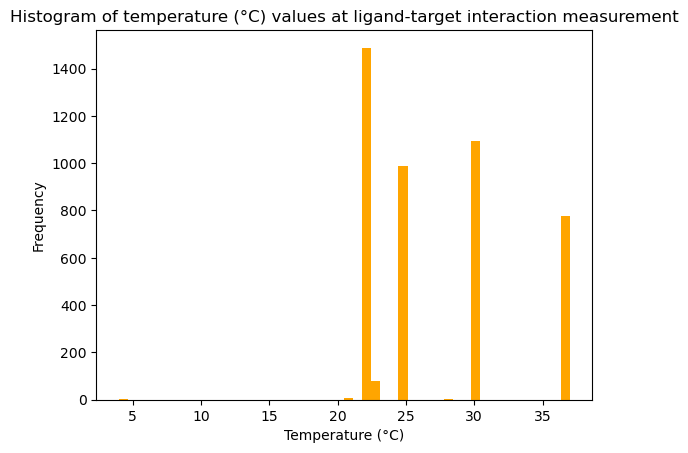

In [252]:
# Plot the Temp (C) values

plt.hist(df['Temp (C)'], bins=50, color='orange')
plt.title("Histogram of temperature (°C) values at ligand-target interaction measurement")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.show()

### *2) pH*

In [253]:
# Examinating the pH 
print(df["pH"].describe())
print(df["pH"].value_counts())

count    3652.000000
mean        7.507749
std         0.285287
min         7.000000
25%         7.400000
50%         7.500000
75%         7.500000
max         8.000000
Name: pH, dtype: float64
pH
7.4    1131
7.5     987
8.0     744
7.2     396
7.0     252
7.6     142
Name: count, dtype: int64


All the pH values are in the range [7.0:8.0], which is a reasonable range when talking about protein interactions in cells. 

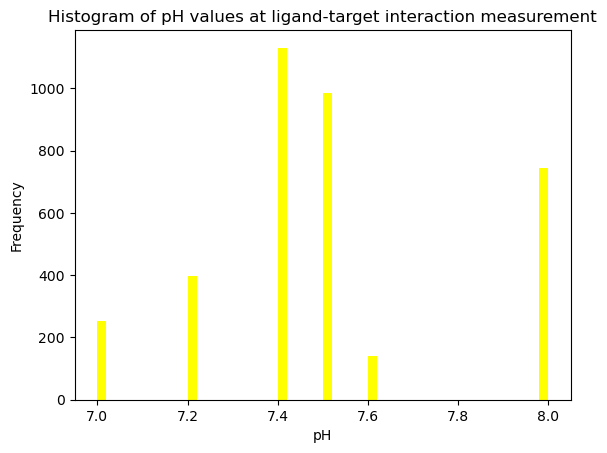

In [254]:
# Plot the pH values

plt.hist(df['pH'], bins=50, color='yellow')
plt.title("Histogram of pH values at ligand-target interaction measurement")
plt.xlabel("pH")
plt.ylabel("Frequency")
plt.show()

### *3) Ki* 

In [255]:
# Call the 'clean' function in the 'function.py' python file
# Remove >, < and spaces and return an integer
Ki_df = df['Ki (nM)'].apply(lambda ki: fc.clean(ki))
Ki_df = Ki_df.dropna(axis=0)
Ki_df.describe()

count      260.000000
mean      2778.834615
std       5649.197769
min          1.000000
25%         69.750000
50%        300.000000
75%       1357.500000
max      20000.000000
Name: Ki (nM), dtype: float64

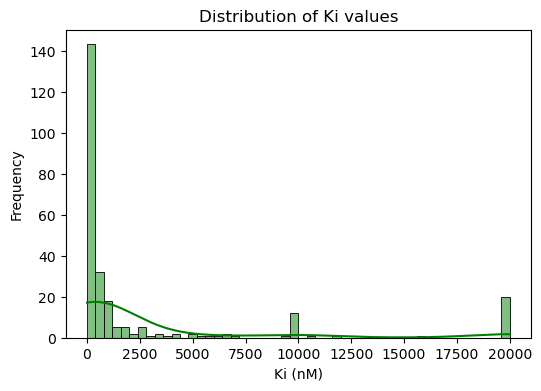

In [256]:
# Plotting the distribution of Ki values
plt.figure(figsize=(6, 4))
sns.histplot(Ki_df, bins=50, kde=True, color='green')
plt.title("Distribution of Ki values")
plt.xlabel("Ki (nM)")
plt.ylabel("Frequency")
plt.show()

A majority of the values are close to 0, corresponding to a strong interaction. We can also see that there are oulayers values around 20000nM that show no binding affinity. However, due to the small size of this sample, we need to find another constant more representative of the whole data! 

### *4) IC50*

In [257]:
IC50_df = df['IC50 (nM)'].apply(lambda ic: fc.clean(ic)) # clean the values
IC50_df = IC50_df.dropna()
IC50_df[IC50_df > 20000] = np.nan # some very high values (no interaction) make the distribution not readable and relevant so we decided to remove them
IC50_df.describe()

count     5956.000000
mean      2849.751175
std       5285.661834
min          1.000000
25%         35.000000
50%        240.000000
75%       2300.000000
max      20000.000000
Name: IC50 (nM), dtype: float64

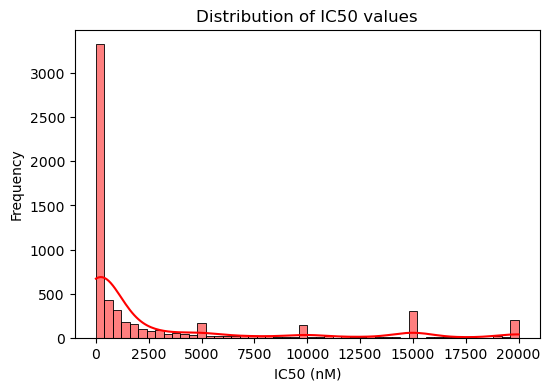

In [258]:
# Plotting the distribution of IC50 values
plt.figure(figsize=(6, 4))
sns.histplot(IC50_df, bins=50, kde=True, color='red')
plt.title("Distribution of IC50 values")
plt.xlabel("IC50 (nM)")
plt.ylabel("Frequency")
plt.show()

A majority of the values are close to 0, corresponding to a strong interaction. We can also see that there are oulayers values between 10000nM and 20000nM that show no binding affinity. Luckily, for this binding affinity constant, the big size of the sample (5956/8227) makes the data significant. 

### *5) Kd*

In [259]:
Kd_df = df['Kd (nM)'].apply(lambda kd: fc.clean(kd))
Kd_df = Kd_df.dropna()
Kd_df.describe()


count       423.000000
mean      61653.198582
std       47635.468367
min           8.000000
25%         982.500000
50%      100000.000000
75%      100000.000000
max      100000.000000
Name: Kd (nM), dtype: float64

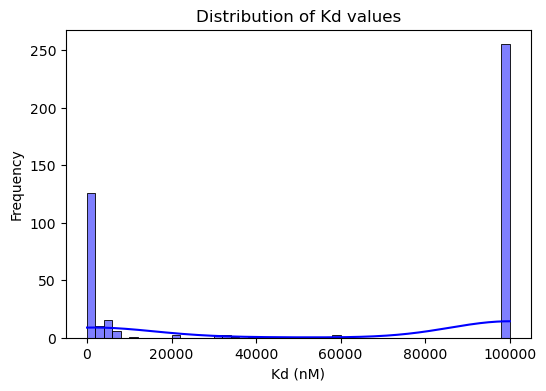

In [260]:
# Plotting the distribution of Kd values
plt.figure(figsize=(6, 4))
sns.histplot(Kd_df, bins=50, kde=True, color='blue')
plt.title("Distribution of Kd values")
plt.xlabel("Kd (nM)")
plt.ylabel("Frequency")
plt.show()

Most of the values indicate no interaction between ligands and targets (>100'000), and we therefore choose to not use them in our analysis. 

### *6) EC50*

In [261]:
df['EC50 (nM)'].value_counts() 

EC50 (nM)
70.0    1
Name: count, dtype: int64

There is a unique value of 70nM for the EC50 values so no comparisons would be possible between the ligand-target binding interactions 

### *7) kon*

In [262]:
df['kon (M-1-s-1)'].describe()

count    4.800000e+01
mean     2.996319e+05
std      7.309514e+05
min      2.350000e+04
25%      7.130000e+04
50%      1.105000e+05
75%      2.122500e+05
max      4.680000e+06
Name: kon (M-1-s-1), dtype: float64

There are only 48 values for kon, which is not enough to draw any conclusion. As seen before, we will use IC50 for our analysis. 

### *9) koff*

In [263]:
df['koff (s-1)'].describe()

count    48.000000
mean      0.213619
std       0.547242
min       0.002300
25%       0.010000
50%       0.020550
75%       0.077675
max       3.150000
Name: koff (s-1), dtype: float64

Same as before, there are not enough values to get additional information to what we will already have from IC50. 

From these analysis, we realized that most of the affinity informations are the IC50 values and we therefore decided to only work with this. Here is the cleaned dataframe that we will use for our further analysis. 

In [264]:
df['IC50 (nM)'] = df['IC50 (nM)'].apply(lambda ic: fc.clean(ic))
df[df['IC50 (nM)']> 20000] = np.nan
df_cleaned = df.dropna(subset=['IC50 (nM)']).copy()
df_cleaned = df_cleaned.drop_duplicates()

### *11) Explorating CDKs and ligands* 

We know our data consists of CDKs and ligands. But what are these proteins ? 

In [265]:
# CDKs
print(df_cleaned["Target Name"].unique())
print(f"There are {df_cleaned['Target Name'].unique().size} different CDKs. Some are mutated forms of the original ones. For example Cyclin-A2 [171-432]/Cyclin-dependent kinase 2 is a mutated form of Cyclin-A2/Cyclin-dependent kinase 2")

['Cyclin-dependent kinase/G2/mitotic-specific cyclin- 1'
 'Cyclin-dependent kinase 2' 'Cyclin-dependent kinase 1'
 'Cyclin-dependent kinase 1/G2/mitotic-specific cyclin-B'
 'Cyclin-A2 [171-432]/Cyclin-dependent kinase 2'
 'Cyclin-dependent kinase 4/G1/S-specific cyclin-D1'
 'Cyclin-dependent kinase 2/G1/S-specific cyclin-E1'
 'Cyclin-dependent kinase 4/G1/S-specific cyclin-D1 [L188C]'
 'Cyclin-A2/Cyclin-dependent kinase 2'
 'Cyclin-dependent kinase 6/G1/S-specific cyclin-D1 [L188C]'
 'Cyclin-dependent kinase 5 activator 1 [99-307]'
 'Cyclin-dependent kinase 5 activator 1' 'Cyclin-dependent kinase 4'
 'Cyclin-T1/Cyclin-dependent kinase 9'
 'Cyclin-A2 [171-432]/Cyclin-dependent kinase 2 [L83V,H84D]'
 'Cyclin-A2 [171-432]/Cyclin-dependent kinase 2 [F82H]'
 'Cyclin-A2 [171-432]/Cyclin-dependent kinase 2 [F82H,L83V,H84D]'
 'Cyclin-A2 [171-432]/Cyclin-dependent kinase 2 [F82H,L83V,H84D,K98T]'
 'Cyclin-A2 [171-432]/Cyclin-dependent kinase 2 [K89T]'
 'Cyclin-H/Cyclin-dependent kinase 7'
 'Cycl

In [266]:
# Ligands
print(df_cleaned["BindingDB Ligand Name"].unique())
print(f"There are {df_cleaned['BindingDB Ligand Name'].unique().size} different ligands.")

['3-((4-Methoxyphenyl)-amino)-4-((3-chlorophenyl)amino)-1H-pyrazolo[3,4-d]pyrimidine::4-(Phenylamino)pyrazolo[3,4-d]pyrimidine deriv. 12::4-N-(3-chlorophenyl)-3-N-(4-methoxyphenyl)-1H-pyrazolo[3,4-d]pyrimidine-3,4-diamine'
 '3-((4-Hydroxyphenyl)amino)-4-((3-chlorophenyl)amino)-1H-pyrazolo[3,4-d]pyrimidine::4-(Phenylamino)pyrazolo[3,4-d]pyrimidine deriv. 13::4-({4-[(3-chlorophenyl)amino]-1H-pyrazolo[3,4-d]pyrimidin-3-yl}amino)phenol'
 '3-((3-Methoxyphenyl)amino)-4-((3-chlorophenyl)amino)-1H-pyrazolo[3,4-d]pyrimidine::4-(Phenylamino)pyrazolo[3,4-d]pyrimidine deriv. 14::4-N-(3-chlorophenyl)-3-N-(3-methoxyphenyl)-1H-pyrazolo[3,4-d]pyrimidine-3,4-diamine'
 ...
 'US9670161, 3 5-Fluoro-4-(4-fluoro-2-methoxyphenyl)-N-{6-fIuoro-4-[(methylsulfonyl)methyl]pyridin-2-yl}pyridin-2-amine'
 'US9670161, 4 5-Fluoro-4-(4-fluoro-2-methoxyphenyl)-N-{4-[(methylsulfonyl)methyl]-6-(trifluoromethyl)pyridin-2-yl}pyridine-2-amine'
 'US9670161, 5 N-{6-(Difluoromethyl)-4-[(methylsulfonyl)methyl]pyridin-2-yl}-5-flu

In [267]:
# Checking how many different ligands are there for each CDK
df_cleaned.groupby("Target Name")["BindingDB Ligand Name"].nunique().sort_values(ascending=False)

Target Name
Cyclin-dependent kinase 2/G1/S-specific cyclin-E1                                1026
Cyclin-A2/Cyclin-dependent kinase 2                                               651
Cyclin-dependent kinase 4/G1/S-specific cyclin-D1                                 574
Cyclin-dependent kinase 4                                                         471
Cyclin-dependent kinase 1                                                         435
Cyclin-dependent kinase/G2/mitotic-specific cyclin- 1                             430
Cyclin-dependent kinase 9                                                         409
Cyclin-T1/Cyclin-dependent kinase 9                                               298
Cyclin-dependent kinase 1/G2/mitotic-specific cyclin-B                            270
Cyclin-dependent kinase 2                                                         237
Cyclin-dependent kinase 4/G1/S-specific cyclin-D1 [L188C]                         185
Cyclin-dependent kinase 5 activator 1 [99-

As the target's names are very long and not easy to use, we decided to transform them into a more concise form. For example we transformed *Cyclin-A2 [171-432]/Cyclin-dependent kinase 2 [F82H]* into *CDK2[F82H]-CycA2[171-432]*. 

In [268]:
df_cleaned['Cleaned Target Name'] = df_cleaned.apply(fc.clean_target_name, axis=1)

----------------------
> ## CDKs: Can we sort them by families? 


<a id="section-3"></a>

Now we want to look at similarities between CDKs.

The most obvious thing we could do is to look at the amino acid sequences of the CDKs. We want to see if some of these 30 CDKs are similar or far from each other. 

### 1. Levenshtein distance

Here we regard the amino acid sequence purely as a string. We will first use the Levenshtein distance which is a string metric for measuring the distance between two sequences. This is exactly what we want to do here.

The formula for calculating the Levenshtein distance between two sequences $s_1$ and $s_2$ is

$$\text{dist}_{\text{Levenshtein}}(s_1, s_2) = \sum_{i=1}^{n} \delta(s_1[i], s_2[i]) $$

It counts the minimum number of single-character edits (insertions, deletions, or substitutions) needed to transform one sequence into another. 

For each entry in the sequences, $\delta(s_1[i], s_2[i])$ is:
* 0 if the characters at position $i$ in both sequences are the same,
* 1 if they are different (substitution)
* 1 per character added or removed (insertions/deletions)

The Levenshtein distance will be zero if the sequences are exactly the same. Higher value of the distance will indicate greater dissimilarity between the sequences.

*A small example*

The Levenshtein distance between the sequences:

1. $\text{seq1} = \text{MEDYTK}$
2. $\text{seq1} = \text{MENFQK}$


We’ll compare each character in the two sequences and make the minimum edits needed to transform one sequence into the other.

1. **Position 1**: `"M"` is the same in both sequences, so no edit is needed.
2. **Position 2**: `"E"` is the same in both sequences, so no edit is needed.
3. **Position 3**: `"D"` in `"MEDYTK"` is different from `"N"` in `"MENFQK"`, so we **substitute** `"D"` with `"N"` (1 edit).
4. **Position 4**: `"Y"` in `"MEDYTK"` is different from `"F"` in `"MENFQK"`, so we **substitute** `"Y"` with `"F"` (1 edit).
5. **Position 5**: `"T"` in `"MEDYTK"` is different from `"Q"` in `"MENFQK"`, so we **substitute** `"T"` with `"Q"` (1 edit).
6. **Position 6**: `"K"` is the same in both sequences, so no edit is needed.

**Total Edits (Levenshtein Distance)**: 
The minimum edits required to transform `"MEDYTK"` into `"MENFQK"` are **3 substitutions**.

Thus, the **Levenshtein distance between `"MEDYTK"` and `"MENFQK"` is 3**.


In [269]:
# Sequences
seq1 = "MEDYTK"
seq2 = "menfqk"


# Calculate Levenshtein distance
levenshtein_distance = distance(seq1, seq2)
print(f"The Levenshtein distance between '{seq1}' and '{seq2}' is: {levenshtein_distance}")

The Levenshtein distance between 'MEDYTK' and 'menfqk' is: 6


We see here that the Levenshtein distance differentiate between lower and upper case. So we will have to lower case all the amino acid sequences first!

We can do the same for the whole strings of the CDKs and define a Confusion matrix to summarize our results.

Here we compute for the chain1 of the amino acid sequence.

We will compute the Levenshtein distance via the same package as above (the `Levenshtein.distance` from the python-Levenshtein library) but normalize the score by the sequence length.

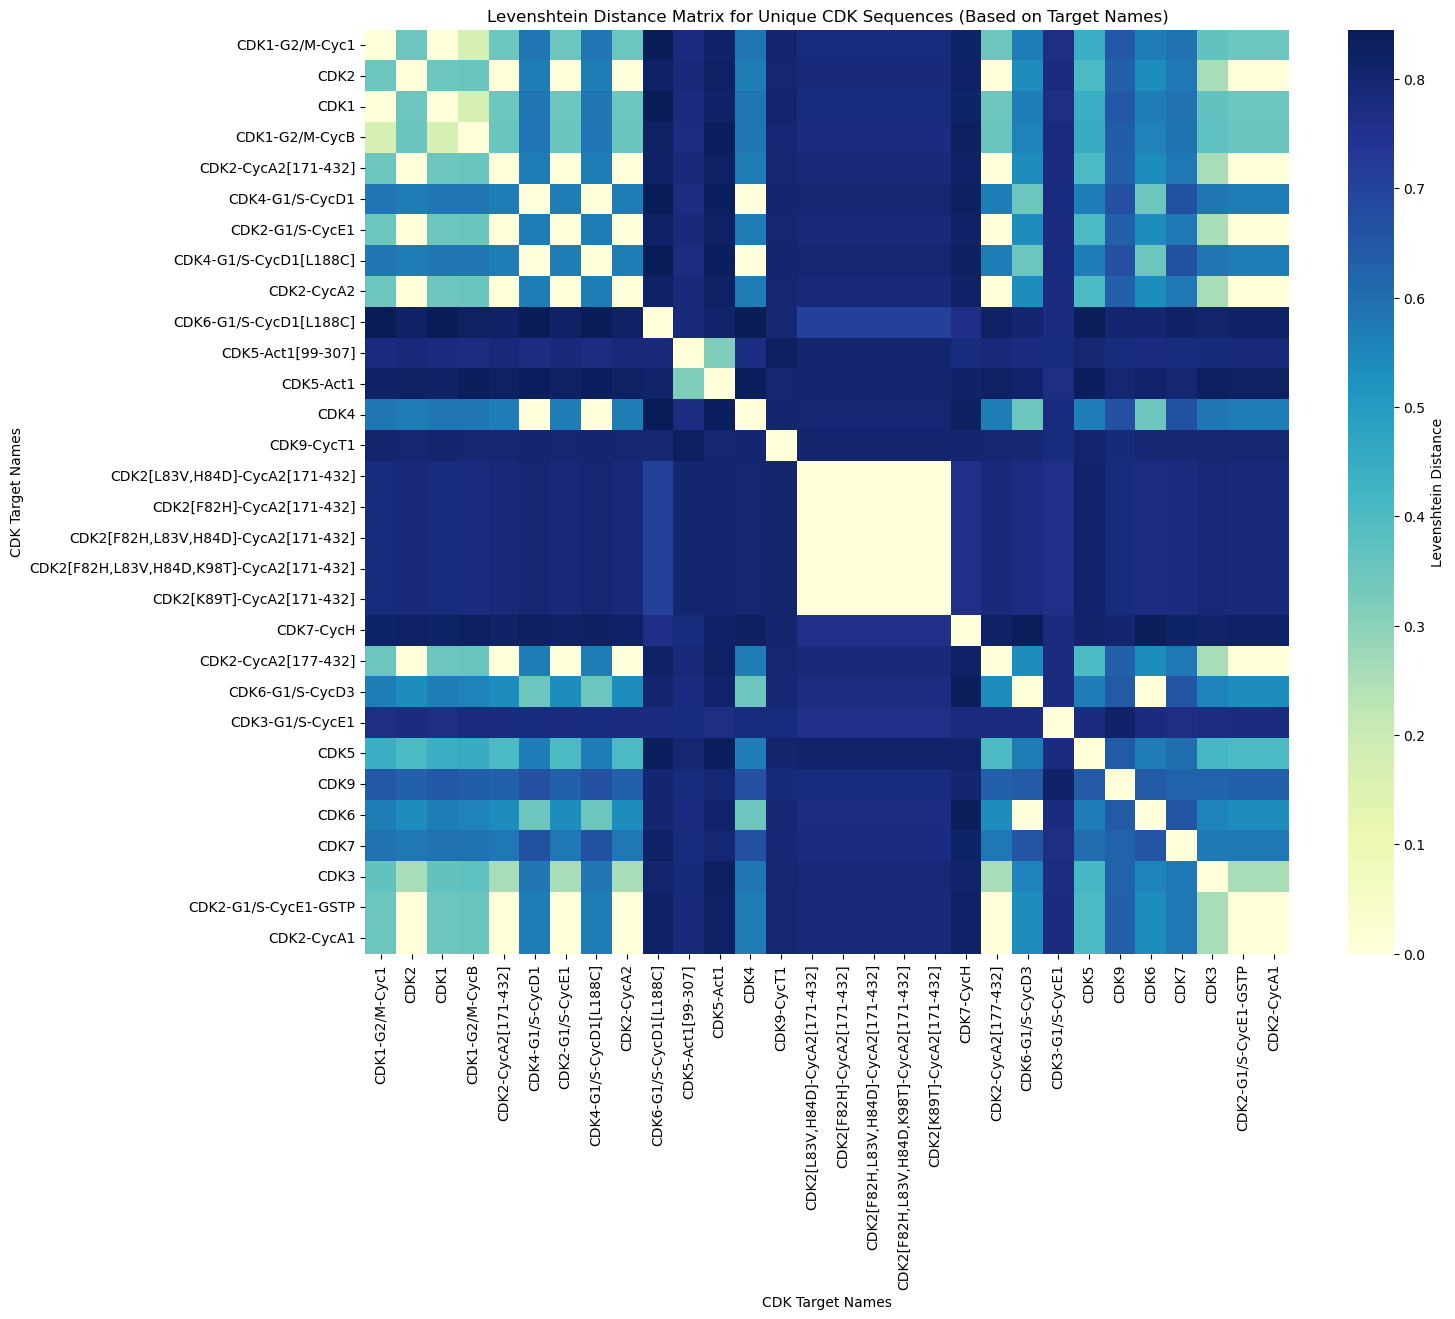

In [270]:
# Plot and store the Levenshtein distances in a matrix
distance_matrix = fc.plot_cdk_confusion_matrix_normalized(df_cleaned, sequence_column="BindingDB Target Chain Sequence", label_column="Cleaned Target Name", plot = True)

We can make the hypothesis that CDKs with close names have similar sequences. For example, the CDKs that contain CDK2 in their name could maybe be gathered in a same family. Let's look deeper at the Levenshtein Distance between 2 CDK2 ("CDK2-CycA2", "CDK2-G1/S-CycE1"). 

In [271]:
# Retrieve the score between the two similar CDKs
cdk_a2_e1_score = distance_matrix.loc["CDK2-CycA2", "CDK2-G1/S-CycE1"]

# Print with specific decimal precision
print(f"Levenshtein Distance (normalized) between CDKs: {cdk_a2_e1_score:.3f}")
print('In this example, we obtain a Levenshtein Distance of 0, meaning they have very high similarity')

Levenshtein Distance (normalized) between CDKs: 0.000
In this example, we obtain a Levenshtein Distance of 0, meaning they have very high similarity


In [272]:
# Get the 10 most similar and 10 least similar CDK pairs with distances
most_similar, least_similar = fc.get_similar_cdks(distance_matrix)

# Display as separate DataFrames
print("Most Similar CDKs (Top 10):")
display(most_similar)

print("\nLeast Similar CDKs (Top 10):")
display(least_similar)

Most Similar CDKs (Top 10):


,Second Amino Acid sequence (chain 1),Second Amino Acid sequence (chain 1),Distance
1,CDK1-G2/M-Cyc1,CDK1,0.0
31,CDK2,CDK2-CycA2[171-432],0.0
33,CDK2,CDK2-G1/S-CycE1,0.0
35,CDK2,CDK2-CycA2,0.0
47,CDK2,CDK2-CycA2[177-432],0.0
55,CDK2,CDK2-G1/S-CycE1-GSTP,0.0
56,CDK2,CDK2-CycA1,0.0
111,CDK2-CycA2[171-432],CDK2-G1/S-CycE1,0.0
113,CDK2-CycA2[171-432],CDK2-CycA2,0.0
125,CDK2-CycA2[171-432],CDK2-CycA2[177-432],0.0



Least Similar CDKs (Top 10):


,Second Amino Acid sequence (chain 1),Second Amino Acid sequence (chain 1),Distance
8,CDK1-G2/M-Cyc1,CDK6-G1/S-CycD1[L188C],0.845118
63,CDK1,CDK6-G1/S-CycD1[L188C],0.845118
138,CDK4-G1/S-CycD1,CDK6-G1/S-CycD1[L188C],0.844884
183,CDK4-G1/S-CycD1[L188C],CDK6-G1/S-CycD1[L188C],0.844884
227,CDK6-G1/S-CycD1[L188C],CDK4,0.844884
381,CDK7-CycH,CDK6-G1/S-CycD3,0.840491
385,CDK7-CycH,CDK6,0.840491
238,CDK6-G1/S-CycD1[L188C],CDK5,0.837288
91,CDK1-G2/M-CycB,CDK5-Act1,0.837134
140,CDK4-G1/S-CycD1,CDK5-Act1,0.833876


Computing the none-normalized Levenshtein measure now to get more insight on how much the sequences length influences the Levenshtein measure:

In [273]:
# Computing the non-normalized Levenshtein
distance_matrix_non_normalized = fc.plot_cdk_confusion_matrix_non_normalized(df_cleaned, sequence_column="BindingDB Target Chain Sequence", label_column="Cleaned Target Name", plot = False)

# Get the 10 most similar and 10 least similar CDK pairs with distances (here using not normalized Levenshtein distances)
most_similar_non_norm, least_similar_non_norm = fc.get_similar_cdks(distance_matrix_non_normalized)

# Display as separate DataFrames
print("Most Similar CDKs (Top 10):")
display(most_similar_non_norm)

print("\nLeast Similar CDKs (Top 10):")
display(least_similar_non_norm)

Most Similar CDKs (Top 10):


,Second Amino Acid sequence (chain 1),Second Amino Acid sequence (chain 1),Distance
1,CDK1-G2/M-Cyc1,CDK1,0.0
31,CDK2,CDK2-CycA2[171-432],0.0
33,CDK2,CDK2-G1/S-CycE1,0.0
35,CDK2,CDK2-CycA2,0.0
47,CDK2,CDK2-CycA2[177-432],0.0
55,CDK2,CDK2-G1/S-CycE1-GSTP,0.0
56,CDK2,CDK2-CycA1,0.0
111,CDK2-CycA2[171-432],CDK2-G1/S-CycE1,0.0
113,CDK2-CycA2[171-432],CDK2-CycA2,0.0
125,CDK2-CycA2[171-432],CDK2-CycA2[177-432],0.0



Least Similar CDKs (Top 10):


,Second Amino Acid sequence (chain 1),Second Amino Acid sequence (chain 1),Distance
247,CDK5-Act1[99-307],CDK9-CycT1,603.0
299,CDK9-CycT1,"CDK2[L83V,H84D]-CycA2[171-432]",586.0
300,CDK9-CycT1,CDK2[F82H]-CycA2[171-432],586.0
301,CDK9-CycT1,"CDK2[F82H,L83V,H84D]-CycA2[171-432]",586.0
302,CDK9-CycT1,"CDK2[F82H,L83V,H84D,K98T]-CycA2[171-432]",586.0
303,CDK9-CycT1,CDK2[K89T]-CycA2[171-432],586.0
308,CDK9-CycT1,CDK5,586.0
12,CDK1-G2/M-Cyc1,CDK9-CycT1,585.0
67,CDK1,CDK9-CycT1,585.0
142,CDK4-G1/S-CycD1,CDK9-CycT1,584.0


In [274]:
# Retrieve the score between the two least similar CDKs
score_not_norm = distance_matrix_non_normalized.loc["CDK5-Act1[99-307]", "CDK9-CycT1"]

# Print with specific decimal precision
print(f"Levenshtein Distance between CDKs: {score_not_norm:.6f}")

Levenshtein Distance between CDKs: 603.000000


In [275]:
# Comparing the length of the least similar sequences
print(len(df_cleaned[df_cleaned["Cleaned Target Name"] == "CDK5-Act1[99-307]"]["BindingDB Target Chain Sequence"].values[0]))
print(len(df_cleaned[df_cleaned["Cleaned Target Name"] == "CDK9-CycT1"]["BindingDB Target Chain Sequence"].values[0].lower()))

209
726


We see here that these two sequences are indead different, but this might be due to that one sequence is much longer than the other (a difference of more than 500 amino acids length). However, we would rather think that CDKs have almost the same sequence's size. This issue could be explained by some parts of the sequences that have been removed or added through the evolution. A better way to compare the amino acid sequences could be to aligh the conserved regions and compare them. This can be done by Multiple sequence alignement, a method more biologically accurate. 

### 2. Multiple sequence alignement

Multiple sequence alignement (MSA) inserts gaps (**-**) into the sequences to align them correctly taking into account their evolutionary and structural homology. 



In [276]:
cdk_sequences = df_cleaned.drop_duplicates(subset='Cleaned Target Name', keep='first')
sequences = pd.DataFrame({
    "CDKs": cdk_sequences['Cleaned Target Name'],
    "Sequences": cdk_sequences['BindingDB Target Chain Sequence']
})
sequences

,CDKs,Sequences
0,CDK1-G2/M-Cyc1,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...
21,CDK2,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...
22,CDK1,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...
66,CDK1-G2/M-CycB,MEDYVKIEKIGEGTYGVVYKGRHKSTGQVVAMKKIRLESEEEGVPS...
75,CDK2-CycA2[171-432],MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...
336,CDK4-G1/S-CycD1,MATSRYEPVAEIGVGAYGTVYKARDPHSGHFVALKSVRVPNGGGGG...
345,CDK2-G1/S-CycE1,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...
1004,CDK4-G1/S-CycD1[L188C],MATSRYEPVAEIGVGAYGTVYKARDPHSGHFVALKSVRVPNGGGGG...
1071,CDK2-CycA2,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...
1457,CDK6-G1/S-CycD1[L188C],mehqllccevetirraypdanllndrvlramlkaeetcapsvsyfk...


Using the function in the *from_DF_to_FASTA.py* contained in the script folder, we created a Fasta file from the CDK sequences of our dataframe 

In [277]:
# Creation of a FASTA file from our dataframe
#dataframe_to_fasta(sequences, id_col="CDKs", seq_col="Sequences", output_file="SequencestobeAligned.fasta")

print("Fichier FASTA créé : SequencestobeAligned.fasta")

Fichier FASTA créé : SequencestobeAligned.fasta


ALIGNEMENT CLUSTER OMEGA ET JAL VIEW

In [278]:
alignment_file = "./data/AlignedSequences.fasta"  
alignment = AlignIO.read(alignment_file, "fasta") 

# Explore the alignement
print(f"Nombre de séquences : {len(alignment)}")
print(f"Longueur de l'alignement : {alignment.get_alignment_length()}")

# Print the 5 first aligned sequences
for record in alignment[:5]:  
    print(f"{record.id}: {record.seq}")



Nombre de séquences : 47
Longueur de l'alignement : 819
CDK3-G1/S-CycE1/1-410: -----------------MPR----E------------------------------------RRERDAKERDTMKEDGGAEFSARSRKRK-------ANVTVF------LQDPDEEMAKIDRTARDQCGSQPWDNNAVCADPCSLIPTPDKE------------------------------------------------------DDDRVYPNSTCKPRIIAPSRGSPLPVLSWANREEVWKIMLNKEKTYLRDQHFLEQHP-----------------------LLQ---------------PKMRAILLDWLM-------------------EVCEVYKLHRETFYLAQD------------------------------------------------------------------------------FFDRYMATQENVVKTLLQLIGISSLFIAAKLEEIYPPKLHQFAYVTDGACSGDEIL-------------TMEL----------MIMKALKWRLSPLTIVSWLNVYMQVA-----------------------------------YLNDLHEVLLPQYPQQIFI-QIAELLDLCVLDVDCLEFPYGILAASALYHFSSSELMQKVSGYQWCDIENCVKWMVPFAMVIRETGSSKLKHFRGVADEDA---H-----NIQTHRDSLDLLDKARAKKAML--SEQNRASPLPSGLLTPPQSGKKQSSGPEMA---------------------------------------------------------------------------------
CDK6-G1/S-CycD1[L188C]/1-295: ------------------------m------------------------------------eh---q----

Let's calculate the similarities between the sequences now that we have well aligned them. 

In [279]:
# Initialisation of a distance matrix
n = len(alignment)
distance_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(i, n):
        score = pairwise2.align.globalxx(alignment[i].seq, alignment[j].seq, score_only=True)
        # Normalization
        similarity = score / max(len(alignment[i].seq), len(alignment[j].seq))
        distance_matrix[i, j] = similarity
        distance_matrix[j, i] = similarity

distance_matrix

array([[1.        , 0.4993895 , 0.63247863, ..., 0.56532357, 0.56410256,
        0.56532357],
       [0.4993895 , 1.        , 0.63980464, ..., 0.63614164, 0.63614164,
        0.63614164],
       [0.63247863, 0.63980464, 1.        , ..., 0.68376068, 0.68376068,
        0.68376068],
       ...,
       [0.56532357, 0.63614164, 0.68376068, ..., 1.        , 0.998779  ,
        0.998779  ],
       [0.56410256, 0.63614164, 0.68376068, ..., 0.998779  , 1.        ,
        0.998779  ],
       [0.56532357, 0.63614164, 0.68376068, ..., 0.998779  , 0.998779  ,
        1.        ]])

In [280]:
# K-means clustering
kmeans = KMeans(n_clusters=7, random_state=42) 
labels = kmeans.fit_predict(distance_matrix)

# Creation of a dictionnary containing the CDKs sorted into their families
famille_dict = {}
for i, cluster_id in enumerate(labels):
    famille_dict.setdefault(cluster_id, []).append(alignment[i].id[:-6])

print("Familles identifiées :")
for cluster_id, membres in famille_dict.items():
    print(f"Famille {cluster_id}: {membres}")

Familles identifiées :
Famille 6: ['CDK3-G1/S-CycE1', 'CDK6-G1/S-CycD1[L188C]', 'CDK5-Act1[99-307]', 'CDK5-Act1', 'CDK7-CycH', 'CDK7']
Famille 2: ['CDK2[K89T]-CycA2[171-432]', 'CDK2[L83V,H84D]-CycA2[171-432]', 'CDK2[F82H]-CycA2[171-432]', 'CDK2[F82H,L83V,H84D]-CycA2[171-432]', 'CDK2[F82H,L83V,H84D,K98T]-CycA2[171-432]']
Famille 5: ['CDK9', 'CDK4-G1/S-CycD1', 'CDK4-G1/S-CycD1[L188C]', 'CDK4', 'CDK6-G1/S-CycD3', 'CDK6']
Famille 3: ['CDK9-CycT1', 'CDK11A', 'CDK11B']
Famille 0: ['CDK19', 'CDK8', 'CDKlike2']
Famille 4: ['CDK14', 'CDK16', 'CDK17', 'CDK18[3-474]']
Famille 1: ['CDK5', 'CDK1-G2/M-Cyc1', 'CDK1', 'CDK1-CycA2', 'CDK1-G2/M-CycB', 'CDK3', 'CDK2[A144G]', 'CDK2[F80T]', 'CDK2[C118L,A144C]', 'CDK2[A144C]', 'CDK2', 'CDK2-CycA2[171-432]', 'CDK2-G1/S-CycE1', 'CDK2-CycA2', 'CDK2-CycA2[177-432]', 'CDK2[F80M]', 'CDK2-G1/S-CycE1-GSTP', 'CDK2-CycA1', 'CDK2[C118L]', 'CDK2[C118I]']


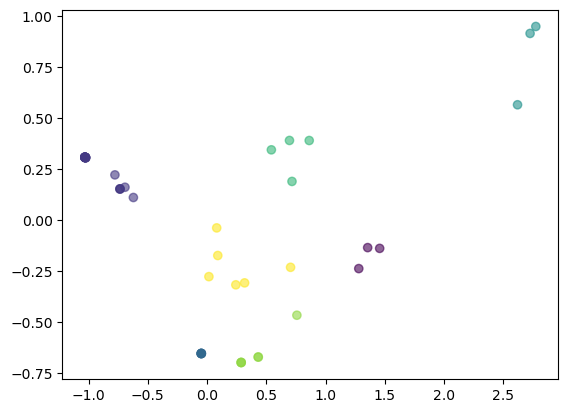

In [281]:
X_reduced_pca = PCA(n_components=2).fit(distance_matrix).transform(distance_matrix)
plt.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=labels, alpha=0.6)

We obtained 6 families of CDKs that we can now use to study the CDKs-Ligands interaction !

----------------------
> ## Binding affinities between ligands and CDKs


<a id="section-3"></a>


### *1) Classes to study the interaction*

We want to study the interactions between ligands and CDKs. We are interested in finding strong inhibitors to CDKs, what interests us is therefore to know wether the ineteraction is strong or not. That's why we decided to classify the binding affinities into 3 interaction groups. 

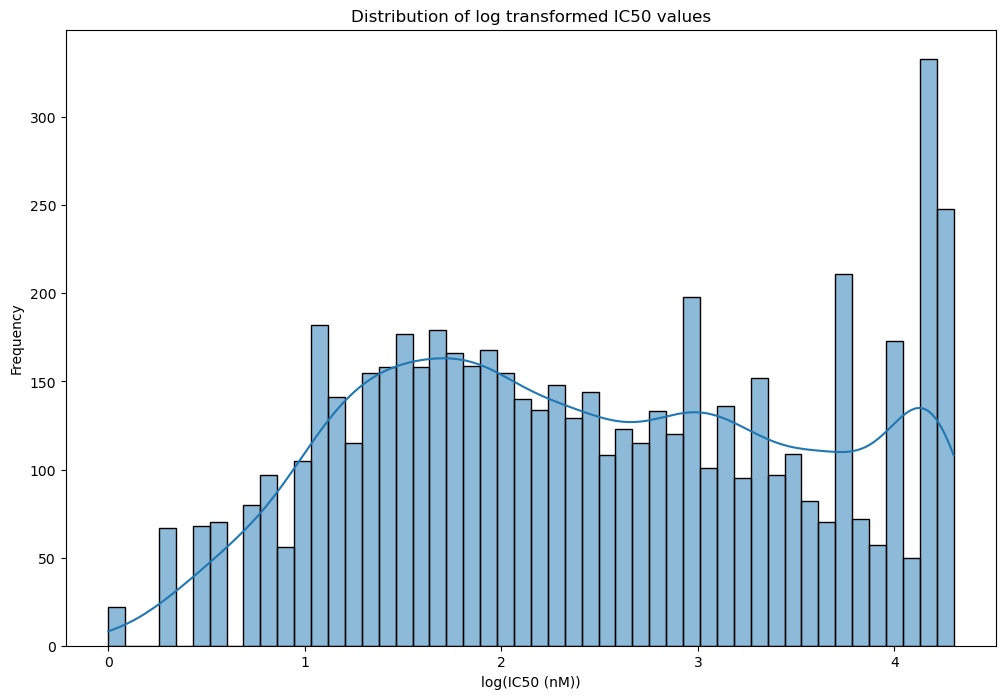

In [282]:
# Still pretty heavy tailed distribution, let's try to log transform the data
affinities_df = df_cleaned.copy()
affinities_df["IC50_log"] = np.log10(affinities_df["IC50 (nM)"])

# Plotting the distribution of log transformed IC50 values
plt.figure(figsize=(12, 8))
sns.histplot(affinities_df["IC50_log"], bins=50, kde=True)
plt.title("Distribution of log transformed IC50 values")
plt.xlabel("log(IC50 (nM))")
plt.ylabel("Frequency")
plt.show()

We chose to divide the IC50 values into 3 groups. By doing this, we lose some information but since we are looking for a inhibitor with a certain binding strength, we can use this assumption: 
- IC50 < 100nM : strong interaction
- 100nM < IC50 < 1 000nM : moderate interaction
- IC50 > 1 000nM : weak interaction

In [283]:
affinities_df['IC50_class'] = affinities_df['IC50 (nM)'].apply(lambda value: fc.classify_IC50(value))
affinities_df["BindingDB Ligand Name"] = affinities_df["BindingDB Ligand Name"].apply(lambda x: x[:20] + '...' if len(str(x)) > 20 else x)
affinities_df.head()

,Ligand SMILES,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,Ki (nM),IC50 (nM),Kd (nM),EC50 (nM),kon (M-1-s-1),koff (s-1),...,UniProt (TrEMBL) Entry Name of Target Chain,BindingDB Target Chain Sequence.1,UniProt (SwissProt) Entry Name of Target Chain.1,UniProt (TrEMBL) Entry Name of Target Chain.1,BindingDB Target Chain Sequence.2,UniProt (SwissProt) Entry Name of Target Chain.2,UniProt (TrEMBL) Entry Name of Target Chain.2,Cleaned Target Name,IC50_log,IC50_class
0,COc1ccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23)cc1,3-((4-Methoxyphenyl)...,Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,NaN,5800.0,NaN,NaN,NaN,NaN,...,NaN,MALRVTRNSKINAENKAKINMAGAKRVPTAPAATSKPGLRPRTALG...,CCNB1_HUMAN,NaN,NaN,NaN,NaN,CDK1-G2/M-Cyc1,3.763428,weak
1,Oc1ccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23)cc1,3-((4-Hydroxyphenyl)...,Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,NaN,1000.0,NaN,NaN,NaN,NaN,...,NaN,MALRVTRNSKINAENKAKINMAGAKRVPTAPAATSKPGLRPRTALG...,CCNB1_HUMAN,NaN,NaN,NaN,NaN,CDK1-G2/M-Cyc1,3.000000,weak
2,COc1cccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23)c1,3-((3-Methoxyphenyl)...,Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,NaN,4300.0,NaN,NaN,NaN,NaN,...,NaN,MALRVTRNSKINAENKAKINMAGAKRVPTAPAATSKPGLRPRTALG...,CCNB1_HUMAN,NaN,NaN,NaN,NaN,CDK1-G2/M-Cyc1,3.633468,weak
3,Oc1cccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23)c1,3-((3-Hydroxyphenyl)...,Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,NaN,3000.0,NaN,NaN,NaN,NaN,...,NaN,MALRVTRNSKINAENKAKINMAGAKRVPTAPAATSKPGLRPRTALG...,CCNB1_HUMAN,NaN,NaN,NaN,NaN,CDK1-G2/M-Cyc1,3.477121,weak
5,Nc1ccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23)cc1,3-((4-Aminophenyl)am...,Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,NaN,10000.0,NaN,NaN,NaN,NaN,...,NaN,MALRVTRNSKINAENKAKINMAGAKRVPTAPAATSKPGLRPRTALG...,CCNB1_HUMAN,NaN,NaN,NaN,NaN,CDK1-G2/M-Cyc1,4.000000,weak


In [284]:
affinities_df['IC50_class'].value_counts()

IC50_class
strong      2346
weak        2096
moderate    1514
Name: count, dtype: int64

In [285]:
IC50_pivot = pd.pivot_table(
    data=affinities_df,
    values=["IC50_class"],
    index=["Cleaned Target Name"],
    columns=["BindingDB Ligand Name"],
    aggfunc="first"
)

mapping = {
    'strong' : 1,
    'moderate' : 2,
    'weak' : 3,
}

IC50_pivot = IC50_pivot.replace(mapping).fillna(0)


/var/folders/sm/bpqf8wpj6478c8rtz31k076r0000gn/T/ipykernel_96920/4241562651.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  IC50_pivot = IC50_pivot.replace(mapping).fillna(0)


In [286]:
IC50_pivot.head()

IC50_class                          \
BindingDB Ligand Name ((2-chloro-5-methyl-... (+)-(S)-(Z)-1-[3-(3-...   
Cleaned Target Name                                                     
CDK1                                      0.0                     0.0   
CDK1-G2/M-Cyc1                            0.0                     0.0   
CDK1-G2/M-CycB                            0.0                     0.0   
CDK2                                      0.0                     0.0   
CDK2-CycA1                                0.0                     0.0   

                                                                       \
BindingDB Ligand Name (+)-(S)-(Z)-4-(3-Hyd... (+)-K-252a::CHEMBL28...   
Cleaned Target Name                                                     
CDK1                                      0.0                     0.0   
CDK1-G2/M-Cyc1                            0.0                     0.0   
CDK1-G2/M-CycB                            0.0                     0.0   
CDK2                                      0.0                     0.0   
CDK2-CycA1                                0.0                     0.0   

                                                                       \
BindingDB Ligand Name (+/-)-(3SR,4RS)-2-(E... (+/-)-(3SR,4RS)-2-(P...   
Cleaned Target Name                                                     
CDK1                                      0.0                     0.0   
CDK1-G2/M-Cyc1                            2.0                     2.0   
CDK1-G2/M-CycB                            0.0                     0.0   
CDK2                                      0.0                     0.0   
CDK2-CycA1                                0.0                     0.0   

                                                                       \
BindingDB Ligand Name (+/-)-(3SR,4RS)-2-(t... (+/-)-(3SR,4RS)-2-N-...   
Cleaned Target Name                                                     
CDK1                                      0.0                     0.0   
CDK1-G2/M-Cyc1                            1.0                     3.0   
CDK1-G2/M-CycB                            0.0                     0.0   
CDK2                                      0.0                     0.0   
CDK2-CycA1                                0.0                     0.0   

                                                                       ...  \
BindingDB Ligand Name (+/-)-(3SR,4RS)-2-[(... (+/-)-N-[5-[[[5-(1,1...  ...   
Cleaned Target Name                                                    ...   
CDK1                                      0.0                     0.0  ...   
CDK1-G2/M-Cyc1                            3.0                     0.0  ...   
CDK1-G2/M-CycB                            0.0                     0.0  ...   
CDK2                                      0.0                     0.0  ...   
CDK2-CycA1                                0.0                     0.0  ...   

                                                                       \
BindingDB Ligand Name ethyl 3-(4-methoxyph... ethyl 3-(4-methylphe...   
Cleaned Target Name                                                     
CDK1                                      0.0                     0.0   
CDK1-G2/M-Cyc1                            0.0                     0.0   
CDK1-G2/M-CycB                            0.0                     0.0   
CDK2                                      0.0                     0.0   
CDK2-CycA1                                0.0                     0.0   

                                                                       \
BindingDB Ligand Name ethyl 3-[4-(butylsul... indazole-benzimidazo...   
Cleaned Target Name                                                     
CDK1                                      0.0                     0.0   
CDK1-G2/M-Cyc1                            0.0                     0.0   
CDK1-G2/M-CycB                            0.0                     0.0   
CDK2                                      0.0  

### *2) Visualization of the ligand-CDK interactions*

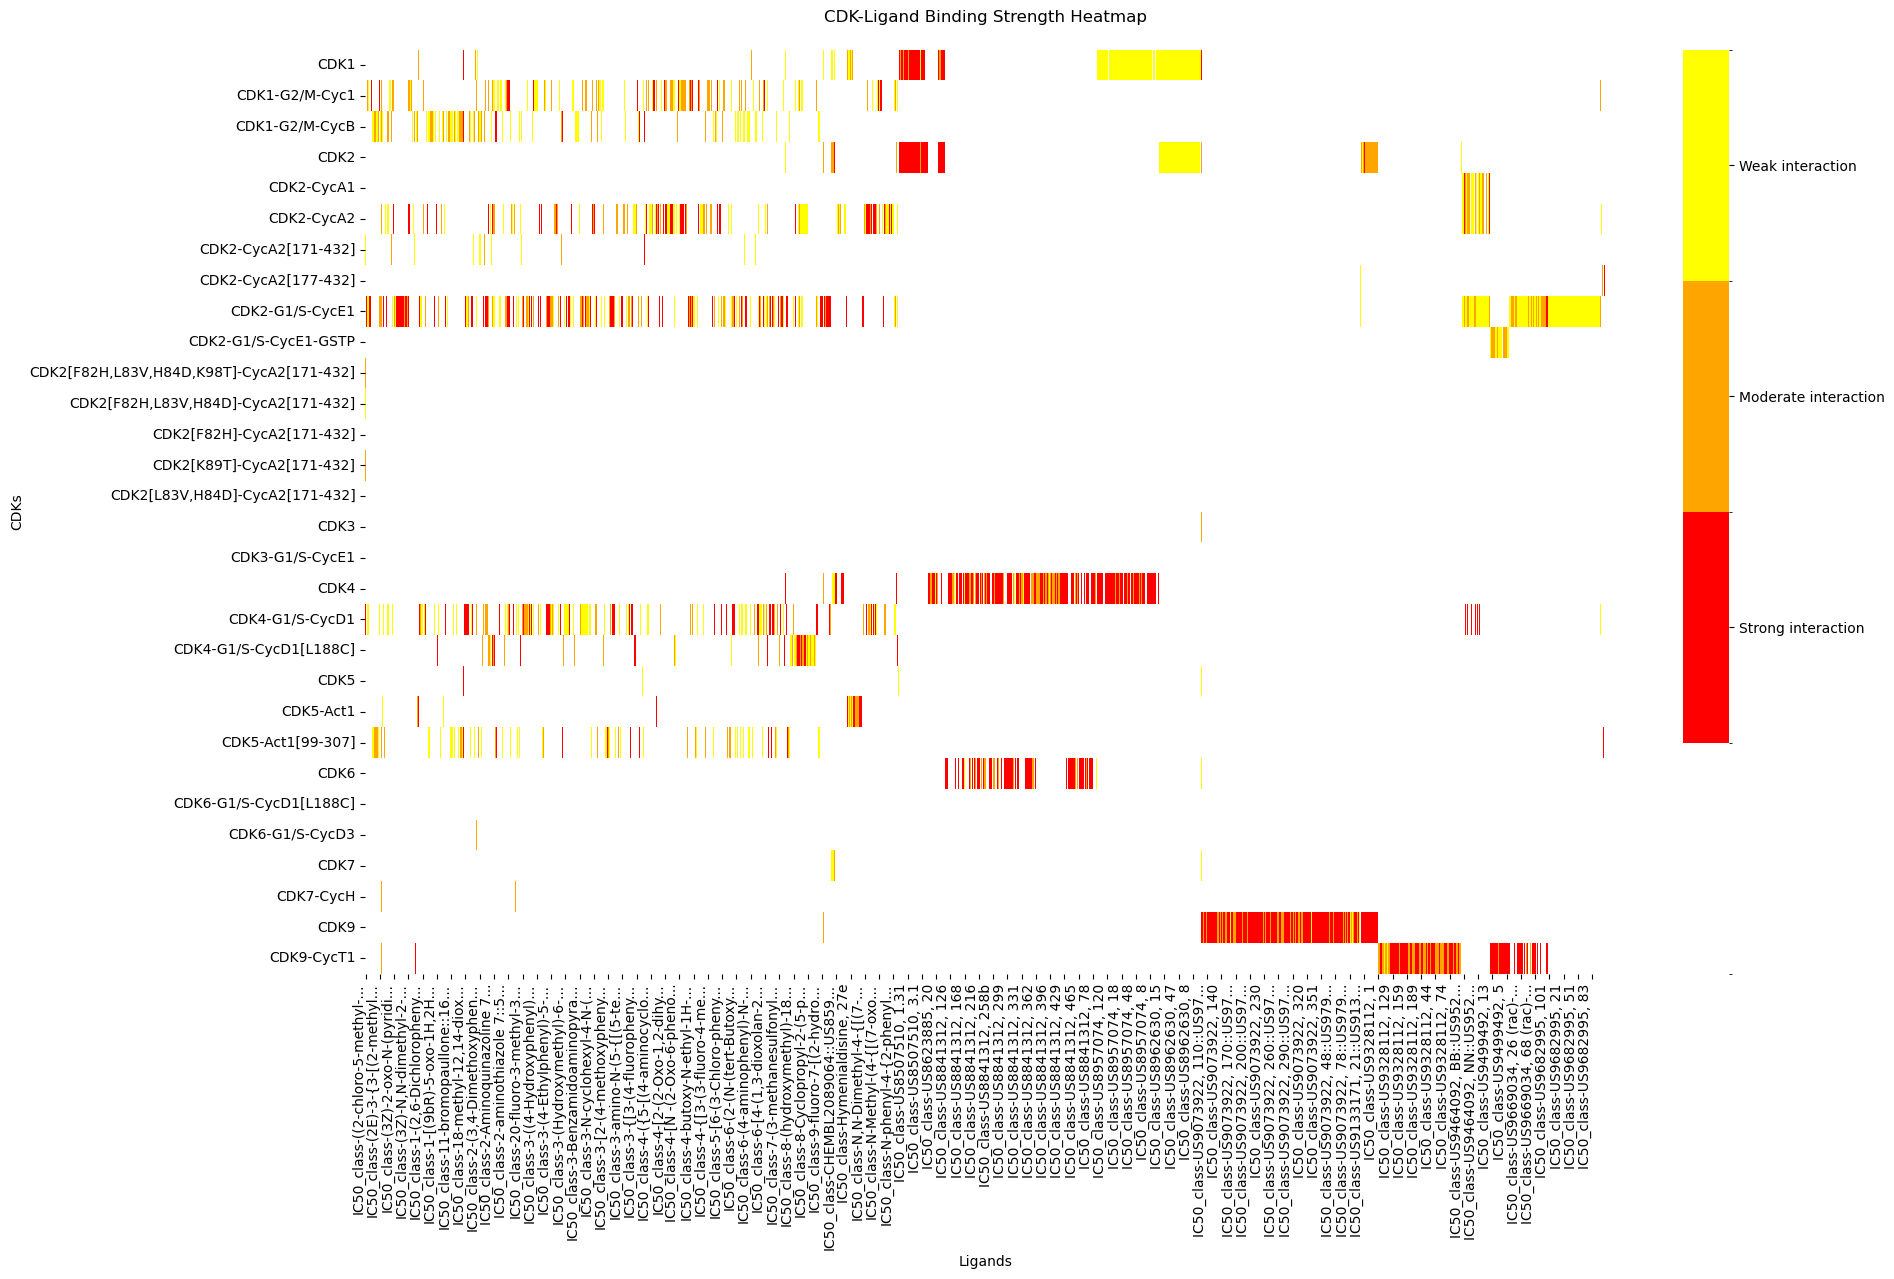

In [287]:
plt.figure(figsize=(20, 12))


discrete_colormap = mcolors.ListedColormap(["white", "red", "orange", "yellow"])

bounds = [0,1,2,3,4]
norm = mcolors.BoundaryNorm(bounds, discrete_colormap.N)

ax = sns.heatmap(
    IC50_pivot,
    cmap=discrete_colormap,
    norm=norm,
    annot=False,  # Too many values to annotate
    cbar_kws={'ticks': [0, 1, 2]}
)

cbar = plt.gca().collections[0].colorbar
cbar.set_ticks([1.5, 2.5, 3.5])
cbar.set_ticklabels(['Strong interaction', 'Moderate interaction', 'Weak interaction'])

plt.title("CDK-Ligand Binding Strength Heatmap", pad=20)
plt.xlabel("Ligands")
plt.ylabel('CDKs')

# Rotate x-axis labels for readability
plt.xticks(rotation=90, ha="right")
plt.yticks(rotation=0)


plt.show()

Where can we find similarities between CDKs and ligands? 

From this heatmap, we observed that the similarities seem to be matching the CDK families. Let's take the example of 2 different CDK2. 

### *3) Interaction similarities within CDK families*

In [288]:
CDK2_affinities_df = affinities_df[affinities_df["Cleaned Target Name"].isin(["CDK2-G1/S-CycE1", "CDK2-CycA2"])]

CDK2_affinities_pivot = pd.pivot_table(
    data=CDK2_affinities_df,
    values=["IC50_class"],
    index=["Cleaned Target Name"],
    columns=["BindingDB Ligand Name"],
    aggfunc="first"
)

mapping = {
    'strong' : 1,
    'moderate' : 2,
    'weak' : 3
}

CDK2_affinities_pivot = CDK2_affinities_pivot.replace(mapping)

# Remove columns with any NaN values
CDK2_affinities_pivot = CDK2_affinities_pivot.dropna(axis=1)

# Fill remaining NaNs with 0 if needed for plotting
CDK2_affinities_pivot = CDK2_affinities_pivot.fillna(0)

/var/folders/sm/bpqf8wpj6478c8rtz31k076r0000gn/T/ipykernel_96920/2657664006.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  CDK2_affinities_pivot = CDK2_affinities_pivot.replace(mapping)


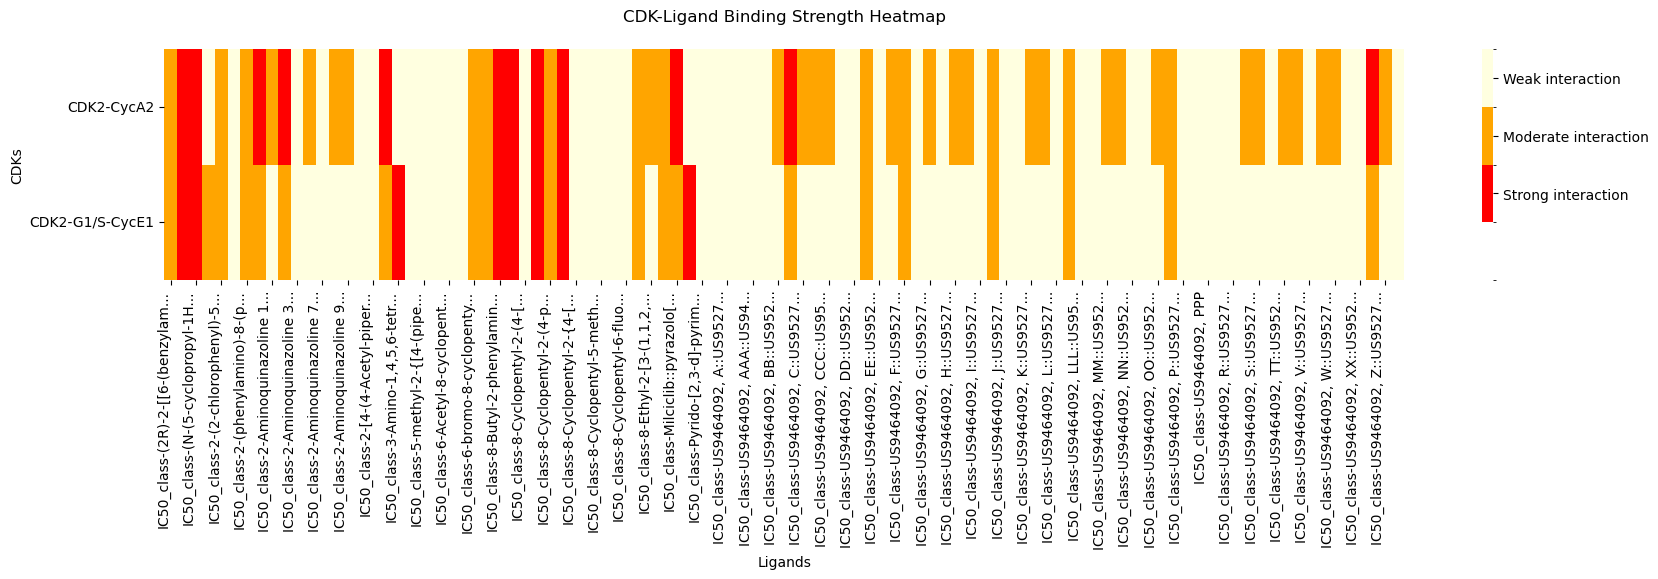

In [289]:
plt.figure(figsize=(20, 3))


discrete_colormap = mcolors.ListedColormap(["white","red",  "orange", "lightyellow"])

bounds = [0,1,2,3,4]
norm = mcolors.BoundaryNorm(bounds, discrete_colormap.N)

ax = sns.heatmap(
    CDK2_affinities_pivot,
    cmap=discrete_colormap,
    norm=norm,
    annot=False,  # Too many values to annotate
        cbar_kws={'ticks': [0, 1, 2]}
)

cbar = plt.gca().collections[0].colorbar
cbar.set_ticks([1.5, 2.5, 3.5])
cbar.set_ticklabels(['Strong interaction', 'Moderate interaction', 'Weak interaction'])
plt.title("CDK-Ligand Binding Strength Heatmap", pad=20)
plt.xlabel("Ligands")
plt.ylabel("CDKs")

# Rotate x-axis labels for readability
plt.xticks(rotation=90, ha="right")
plt.yticks(rotation=0)


plt.show()

In [290]:
# Calculate the percentage of interaction similarity between the 2 CDK2
comparison_pivot = CDK2_affinities_pivot.copy()
comparison_pivot.loc['Comparison'] = (CDK2_affinities_pivot.iloc[0] == CDK2_affinities_pivot.iloc[1]).astype(int)
percentage_of_similarities = (comparison_pivot.loc['Comparison'].sum() / len(comparison_pivot.loc['Comparison'])) * 100
print(f"The 2 interaction arrays are {percentage_of_similarities:.2f}% similar.")

The 2 interaction arrays are 65.31% similar.


The interaction arrays of these two CDK2 definitly show similarities. 

Are there similarities in the amino sequence that explain these similarities?


----------------------
> ## Ligands' SMILES


<a id="section-5"></a>

For this milestone we have visually inspected the heatmap to indentify which groups of ligands we wish to compare. 
**For the next milestone this part of the process will be automated by considering all combinations of strong interactions.**

Now the question arises, if a group of ligands binds strongly to the same group of CDKs is it because the ligands have similar structural features?

From the categorical heatmap of ligands interacting with the CDKs we have identified 2 interesting cases to compare to reason about this question:

Case 1: Strong ligand interactions with Cyclin-A2/Cyclin-dependent kinase 2 & Cyclin-dependent kinase 2/G1/S-specific cyclin-E1
* Since they are both different variant of CDK2 their amino acide sequence is very similar. 

Case 2: Strong ligand interactions with Cyclin-dependent kinase 2/G1/S-specific cyclin-E1 & Cyclin-dependent kinase 4/G1/S-specific cyclin-D1
* This case was mainly deemed interesting due to the amount of data available across the 2 CDKs. The same ligands have been tested on both CDKs and shows strong affinities.

To investigate these cases we will make use of the infamous industry standard for Cheminformatics, namely the Tanimoto similarity coefficient. 
This model compares 2 different SMILES strings and returns a value between 0 and 1. 1 being identical and 0 being completely different. To know more about Tanimoto see: 
https://www.rdkit.org/docs/GettingStartedInPython.html . Values > 0.85 are in this case considered similar. Ref: https://en.wikipedia.org/wiki/Chemical_similarity 


### *1) Comparing between Cyclin-A2/Cyclin-dependent kinase 2 & Cyclin-dependent kinase 2/G1/S-specific cyclin-E1*


In [291]:
IC50_df = df_cleaned[
    [
        "Ligand SMILES",
        "BindingDB Ligand Name",
        "Target Name",
        "Target Source Organism According to Curator or DataSource",
        "IC50 (nM)",
        "BindingDB Target Chain Sequence",
        "UniProt (SwissProt) Entry Name of Target Chain",
    ]
]

IC50_df.groupby(
    [
        "Ligand SMILES",
        "BindingDB Ligand Name",
        "Target Name",
        "Target Source Organism According to Curator or DataSource",
        "BindingDB Target Chain Sequence",
        "UniProt (SwissProt) Entry Name of Target Chain",
    ]
)["IC50 (nM)"].median().reset_index()

IC50_df["IC50_class"] = IC50_df["IC50 (nM)"].apply(
    lambda value: fc.classify_IC50(value)
)

IC50_ligand_strong = IC50_df[IC50_df["IC50_class"] == "strong"]
IC50_ligand_strong.groupby("BindingDB Ligand Name")

strong_ligands_cdks_2 = fc.create_df_on_intersection_of_values(
    IC50_ligand_strong,
    "Target Name",
    "Cyclin-A2/Cyclin-dependent kinase 2",
    "Cyclin-dependent kinase 2/G1/S-specific cyclin-E1",
    "BindingDB Ligand Name",
)


/var/folders/sm/bpqf8wpj6478c8rtz31k076r0000gn/T/ipykernel_96920/1569308504.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IC50_df["IC50_class"] = IC50_df["IC50 (nM)"].apply(


In [292]:
# Create a similarity matrix between the 2 CDK2's ligands SMILES
similarity_matrix_cdks_2 = fc.ligand_similarity_matrix(strong_ligands_cdks_2)
similarity_matrix_cdks_2.head()

,"8-Butyl-2-phenylamino-8H-pyrido[2,3-d]pyrimidin-7-one::8-butyl-2-(phenylamino)-7H,8H-pyrido[2,3-d]pyrimidin-7-one::N8 Pyrido[2,3-d]pyrimidin-7-one deriv. 42","8-Cyclohexyl-2-[4-(4-methylpiperazin-1-yl)phenylamino]-8H-pyrido[2,3-d]pyrimidin-7-one::8-cyclohexyl-2-{[4-(4-methylpiperazin-1-yl)phenyl]amino}-7H,8H-pyrido[2,3-d]pyrimidin-7-one::N8 Pyrido[2,3-d]pyrimidin-7-one deriv. 70","8-Cyclopentyl-2-[4-(4-methylpiperazin-1-yl)phenylamino]-8H-pyrido[2,3-d]pyrimidin-7-one::8-cyclopentyl-2-{[4-(4-methylpiperazin-1-yl)phenyl]amino}-7H,8H-pyrido[2,3-d]pyrimidin-7-one::FRAX019::N8 Pyrido[2,3-d]pyrimidin-7-one deriv. 68::Pyrido[2,3-d]pyrimidin-7-one 1","8-Cyclopentyl-2-(4-morpholin-4-yl-phenylamino)-8H-pyrido[2,3-d]pyrimidin-7-one::8-cyclopentyl-2-{[4-(morpholin-4-yl)phenyl]amino}-7H,8H-pyrido[2,3-d]pyrimidin-7-one::Pyrido[2,3-d]pyrimidin-7-one 2","8-Cyclopentyl-2-(4-piperazin-1-yl-phenylamino)-8H-pyrido[2,3-d]pyrimidin-7-one::8-cyclopentyl-2-{[4-(piperazin-1-yl)phenyl]amino}-7H,8H-pyrido[2,3-d]pyrimidin-7-one::Pyrido[2,3-d]pyrimidin-7-one 5",(N-(5-cyclopropyl-1H-pyrazol-3-yl)-2-(2-naphthyl)acetamide::N-(5-cyclopropyl-1H-pyrazol-3-yl)-2-(naphthalen-2-yl)acetamide::PNU-292137,"3-Amino-1,4,5,6-tetrahydropyrrolo[3,4-c]pyrazole 15::N-butyl-3-{2-[4-(pyrrolidin-1-yl)phenyl]acetamido}-1H,4H,5H,6H-pyrrolo[3,4-c]pyrazole-5-carboxamide","3-Amino-1,4,5,6-tetrahydropyrrolo[3,4-c]pyrazole 18::N-butyl-3-[(2S)-2-(naphthalen-2-yl)propanamido]-1H,4H,5H,6H-pyrrolo[3,4-c]pyrazole-5-carboxamide"
"8-Butyl-2-phenylamino-8H-pyrido[2,3-d]pyrimidin-7-one::8-butyl-2-(phenylamino)-7H,8H-pyrido[2,3-d]pyrimidin-7-one::N8 Pyrido[2,3-d]pyrimidin-7-one deriv. 42",1.000000,0.818365,0.819192,0.827551,0.831795,0.238267,0.311047,0.315827
"8-Cyclohexyl-2-[4-(4-methylpiperazin-1-yl)phenylamino]-8H-pyrido[2,3-d]pyrimidin-7-one::8-cyclohexyl-2-{[4-(4-methylpiperazin-1-yl)phenyl]amino}-7H,8H-pyrido[2,3-d]pyrimidin-7-one::N8 Pyrido[2,3-d]pyrimidin-7-one deriv. 70",0.818365,1.000000,0.990955,0.924805,0.975879,0.261789,0.373010,0.361111
"8-Cyclopentyl-2-[4-(4-methylpiperazin-1-yl)phenylamino]-8H-pyrido[2,3-d]pyrimidin-7-one::8-cyclopentyl-2-{[4-(4-methylpiperazin-1-yl)phenyl]amino}-7H,8H-pyrido[2,3-d]pyrimidin-7-one::FRAX019::N8 Pyrido[2,3-d]pyrimidin-7-one deriv. 68::Pyrido[2,3-d]pyrimidin-7-one 1",0.819192,0.990955,1.000000,0.931373,0.984848,0.260976,0.373269,0.361356
"8-Cyclopentyl-2-(4-morpholin-4-yl-phenylamino)-8H-pyrido[2,3-d]pyrimidin-7-one::8-cyclopentyl-2-{[4-(morpholin-4-yl)phenyl]amino}-7H,8H-pyrido[2,3-d]pyrimidin-7-one::Pyrido[2,3-d]pyrimidin-7-one 2",0.827551,0.924805,0.931373,1.000000,0.945274,0.258987,0.373955,0.359184
"8-Cyclopentyl-2-(4-piperazin-1-yl-phenylamino)-8H-pyrido[2,3-d]pyrimidin-7-one::8-cyclopentyl-2-{[4-(piperazin-1-yl)phenyl]amino}-7H,8H-pyrido[2,3-d]pyrimidin-7-one::Pyrido[2,3-d]pyrimidin-7-one 5",0.831795,0.975879,0.984848,0.945274,1.000000,0.264198,0.370474,0.358555


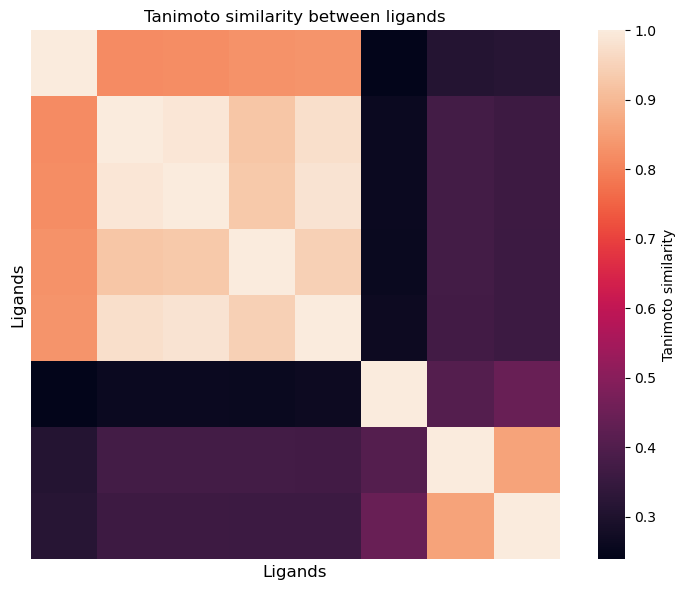

(8, 8)

In [293]:
fc.plot_tanimoto_similarity(similarity_matrix_cdks_2)
similarity_matrix_cdks_2.shape

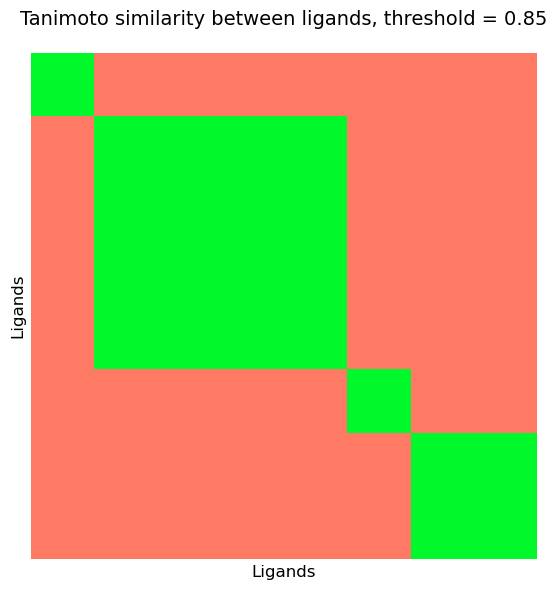

In [294]:
fc.plot_conditional_tanimoto(similarity_matrix_cdks_2)

In [295]:
summary_df_cdks_2 = fc.summary_of_ligand_similarities(similarity_matrix_cdks_2)
summary_df_cdks_2

mean                                        0.557152
std                                         0.283217
min                                         0.238267
max                                         0.990955
no. similar ligands meas. >= 0.85           7.000000
no. of non-similar ligands meas. < 0.85    21.000000
count                                      28.000000
similar ligands %                          25.000000
dtype: float64

We obtained a similarity of 25% between the ligands' SMILES that make strong interactions with the 2 CDK2. It is a good result but it is not enough data to use this information to develop a potential inhibitor to CDK2. Therefore, we decided to continue on the same way but comparing ligands binding to CDKs from different families.  

### *2) Comparing between Cyclin-dependent kinase 2/G1/S-specific cyclin-E1 & Cyclin-dependent kinase 4/G1/S-specific cyclin-D1*

We screened all the CDK pairs (e.g. CDK1/CDK2) and selected this one as it gave the best similarity percentage among their ligands. 

In [296]:
strong_ligands_cdk_24 = fc.create_df_on_intersection_of_values(IC50_ligand_strong,
                                                               "Target Name",
                                                                "Cyclin-dependent kinase 2/G1/S-specific cyclin-E1",
                                                                "Cyclin-dependent kinase 4/G1/S-specific cyclin-D1",
                                                                "BindingDB Ligand Name")


In [297]:
print(strong_ligands_cdk_24.shape)
strong_ligands_cdk_24.head()

(110, 15)


,Ligand SMILES_x,BindingDB Ligand Name,Target Name_x,Target Source Organism According to Curator or DataSource_x,IC50 (nM)_x,BindingDB Target Chain Sequence_x,UniProt (SwissProt) Entry Name of Target Chain_x,IC50_class_x,Ligand SMILES_y,Target Name_y,Target Source Organism According to Curator or DataSource_y,IC50 (nM)_y,BindingDB Target Chain Sequence_y,UniProt (SwissProt) Entry Name of Target Chain_y,IC50_class_y
0,CN(C)c1ccc(cc1)-c1[nH]nc2-c3cccc(NC(=O)CN4CCC(...,"3-(4-(N,N-Dimethylamino)phenyl)-5-(4-hydroxypi...",Cyclin-dependent kinase 2/G1/S-specific cyclin-E1,Homo sapiens,33.0,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,strong,CN(C)c1ccc(cc1)-c1[nH]nc2-c3cccc(NC(=O)CN4CCC(...,Cyclin-dependent kinase 4/G1/S-specific cyclin-D1,Homo sapiens,50.0,MATSRYEPVAEIGVGAYGTVYKARDPHSGHFVALKSVRVPNGGGGG...,CDK4_HUMAN,strong
1,CN(C)c1ccc(cc1)-c1[nH]nc2-c3cccc(NC(=O)CN4CCC(...,2-[4-(aminomethyl)piperidin-1-yl]-N-{3-[4-(dim...,Cyclin-dependent kinase 2/G1/S-specific cyclin-E1,Homo sapiens,15.0,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,strong,CN(C)c1ccc(cc1)-c1[nH]nc2-c3cccc(NC(=O)CN4CCC(...,Cyclin-dependent kinase 4/G1/S-specific cyclin-D1,Homo sapiens,7.0,MATSRYEPVAEIGVGAYGTVYKARDPHSGHFVALKSVRVPNGGGGG...,CDK4_HUMAN,strong
2,CN(C)c1ccc(cc1)-c1[nH]nc2-c3cccc(NC(=O)CN4CCN(...,"3-(4-(N,N-Dimethylamino)phenyl)-5-((4-methylpi...",Cyclin-dependent kinase 2/G1/S-specific cyclin-E1,Homo sapiens,29.0,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,strong,CN(C)c1ccc(cc1)-c1[nH]nc2-c3cccc(NC(=O)CN4CCN(...,Cyclin-dependent kinase 4/G1/S-specific cyclin-D1,Homo sapiens,55.0,MATSRYEPVAEIGVGAYGTVYKARDPHSGHFVALKSVRVPNGGGGG...,CDK4_HUMAN,strong
3,NCC1CCN(CC(=O)Nc2cccc3-c4n[nH]c(c4C(=O)c23)-c2...,2-[4-(aminomethyl)piperidin-1-yl]-N-{3-[4-(mor...,Cyclin-dependent kinase 2/G1/S-specific cyclin-E1,Homo sapiens,26.0,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,strong,NCC1CCN(CC(=O)Nc2cccc3-c4n[nH]c(c4C(=O)c23)-c2...,Cyclin-dependent kinase 4/G1/S-specific cyclin-D1,Homo sapiens,18.0,MATSRYEPVAEIGVGAYGTVYKARDPHSGHFVALKSVRVPNGGGGG...,CDK4_HUMAN,strong
4,NC(=O)C1CCN(CC(=O)Nc2cccc3-c4n[nH]c(C5CC5)c4C(...,"1-[({3-cyclopropyl-4-oxo-2H,4H-indeno[1,2-c]py...",Cyclin-dependent kinase 2/G1/S-specific cyclin-E1,Homo sapiens,26.0,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,strong,NC(=O)C1CCN(CC(=O)Nc2cccc3-c4n[nH]c(C5CC5)c4C(...,Cyclin-dependent kinase 4/G1/S-specific cyclin-D1,Homo sapiens,99.0,MATSRYEPVAEIGVGAYGTVYKARDPHSGHFVALKSVRVPNGGGGG...,CDK4_HUMAN,strong


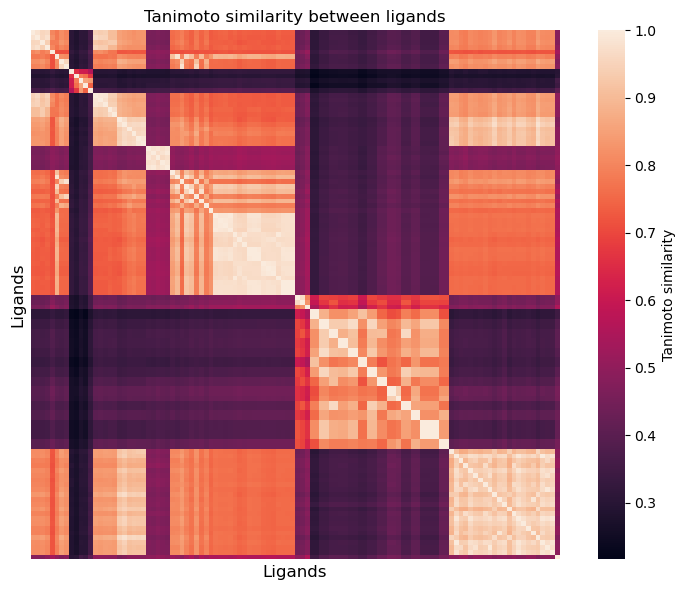

In [298]:
similarity_matrix_cdk_24 = fc.ligand_similarity_matrix(strong_ligands_cdk_24)
fc.plot_tanimoto_similarity(similarity_matrix_cdk_24)

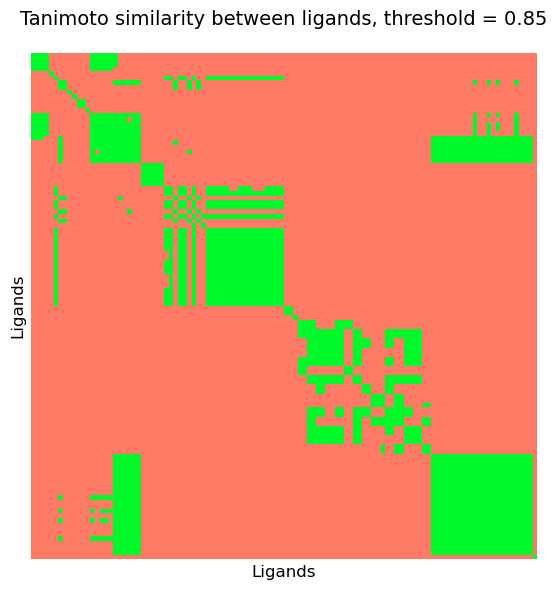

In [299]:
fc.plot_conditional_tanimoto(similarity_matrix_cdk_24)

In [300]:
summary_df_cdk_24 = fc.summary_of_ligand_similarities(similarity_matrix_cdk_24)

In [301]:
summary_df_cdk_24

mean                                          0.583194
std                                           0.229709
min                                           0.216028
max                                           0.998876
no. similar ligands meas. >= 0.85           896.000000
no. of non-similar ligands meas. < 0.85    5085.000000
count                                      5981.000000
similar ligands %                            14.980772
dtype: float64

We obtained a 15% similarity between the ligands SMILES that strongly bind to this CDK2 and this CDK4. As the size of this ligand sample is big enough, it could potentially be used for further analysis. In this deeper researches, we could find repeated patterns in the ligand structure that could be used to develop an inhibitor against CDKs and therefore to stop the uncontrolled cell division in cancer. 

----------------------
> ## Conclusion of milestone P2


<a id="section-7"></a>

In this milestone, we have focused on the CDKs because it sounded feasable. However we feel that we limited the project too much and for milestone 3, we are thinking of including more data either from the initial data or from additional data (e.g. PDP database).
Our exploration to find a potential drug against CDKs is not finished yet and we would for example need to explore deeper into the ligand's structure (e.g. by using N-grams or an clustering algorithm). 